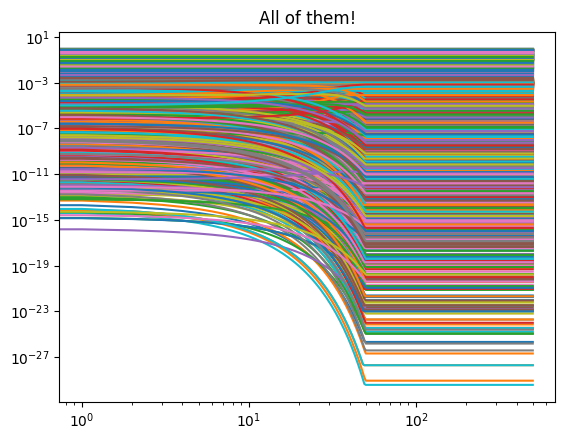

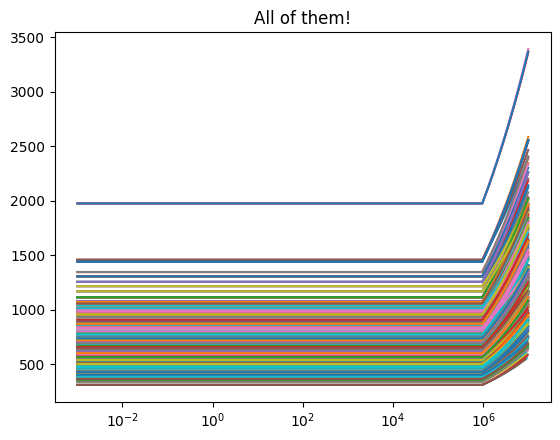

In [9]:
import numpy as np
import os 
import matplotlib.pyplot as plt

comp_directories = ["/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/20250723/20250721_ArielTargetProfileData"]
files = [os.path.join(directory, name) for directory in comp_directories for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name)) and "Compoprofile.csv" in name]

mols = ["H2", "H2O", "CO", "CO2", "CH4", "He"]

# print(idx)

# file_ = files[0]
# data = np.loadtxt(file_, skiprows=3, delimiter=',').T
# fname = file_.split("/")[-1]
# plt.title(fname)
# for m,p in zip(mols[1:-1], data[1:-1]):
#     plt.plot(p, label=m)
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.show()
    
    
for file_ in files:
    data = np.loadtxt(file_, skiprows=3, delimiter=',').T
    plt.title("All of them!")
    for m,p in zip(mols[1:-1], data[1:-1]):
        plt.plot(p, label=m)
plt.xscale("log")
plt.yscale("log")

plt.show()

comp_directories = ["/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/20250723/20250721_ArielTargetProfileData"]
files = [os.path.join(directory, name) for directory in comp_directories for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name)) and "PTprofile.csv" in name]

    
for file_ in files:
    data = np.loadtxt(file_, skiprows=3, delimiter=',').T
    plt.title("All of them!")
    plt.plot(data[0], data[1])
plt.xscale("log")
# plt.yscale("log")

plt.show()

In [10]:
from astropy.io import ascii
from astropy.table import Table

# Load the target list
targetlist = ascii.read('/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/20250723/20250721_ArielTargetSimul_Metadata.csv')

print(targetlist.keys())

# Initialize the output table with the same columns as the target list
out_targetlist = targetlist



['Star Name', 'Star Mass [Ms]', 'Spectral Type', 'Star Temperature [K]', 'Star Radius [Rs]', 'Star Distance [pc]', 'Star K Mag', 'Star V Mag', 'Star Metallicity', 'Star Age [Gyr]', 'Star RA', 'Star Dec', 'Planet Name', 'Planet Period [days]', 'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Radius [Re]', 'Planet Albedo', 'Planet Mass [Me]', 'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter', 'Heat Redistribution Factor', 'Inclination', 'Eccentricity', 'Transit Mid Time', 'Tier', 'Best Method', 'Time [s]', 'Chemistry filename', 'Pressure-Temperature filename', 'COratio', 'OHratio', 'HeHratio', 'Migration Efficiency [Fiducial = 0, Efficient = 1]', 'Redox [Reduced = 0, Oxidized = 1]', 'Accreted Ice/Rock ratio', 'RemainingAtm/InitialAtm', 'InitialAtm/Rock']


In [11]:
from tqdm import tqdm 

comp_folder = "/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/20250723/20250721_ArielTargetProfileData"

for col in ["H2_profile", "He_profile", "H2O_profile", "CO_profile", "CO2_profile", "CH4_profile", "T_profile"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # In

# print(out_targetlist.colnames)

def find_file(path, keyword, kind):
    file_list = os.listdir(path)
    # print(file_list)
    # print(planet_data['Planet Name'].split("_")[0])

    matching_files = [file for file in file_list if keyword + "_" + kind in file and ".csv" in file]
    # print(matching_files)
    return matching_files

for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):

    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    matching_files =find_file(comp_folder, planet_data['Planet Name'].split("_")[0], "Compoprofile")
    fname = os.path.join(comp_folder, matching_files[0])
    # print(out_targetlist["Planet Name"][i], fname.split("/")[-1])
        
    data = ascii.read(fname, format='no_header', comment="#", delimiter=',')

    column_map = ["H2", "H2O", "CO", "CO2", "CH4", "He"]
    data.rename_columns(data.colnames, column_map)
    for column in column_map:
        planet_dict[f"{column}_profile"] = np.median(data[column])    
    
    matching_files =find_file(comp_folder, planet_data['Planet Name'].split("_")[0], "PTprofile")
    fname = os.path.join(comp_folder, matching_files[0])

    data = ascii.read(fname, format='no_header', comment="#", delimiter=',')
    planet_dict[f"T_profile"] = np.median(data["col2"])

    # Ensure the row update follows the correct column order
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]

# print(out_targetlist)


100%|██████████| 460/460 [00:02<00:00, 183.94it/s]


In [12]:
# Add the current notebook's directory to the Python path
import sys
sys.path.append(os.getcwd())

# Now import the function
from mol_to_ratios import calculate_ratios_with_uncertainties

# Ensure the required columns exist in out_targetlist
for col in ["O/H_profile", "C/O_profile", "He/H_profile", "He_profile", "H2_profile", "H_profile", "C_profile", "O_profile"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # Initialize missing columns

# Iterate through each planet in the target list
for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):
    # Convert Row to a dictionary for easier modification
    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    # Retrieve molecular fractions and uncertainties from planet_dict
    H2O = planet_dict.get("H2O_profile", np.nan)
    CO = planet_dict.get("CO_profile", np.nan)
    CO2 = planet_dict.get("CO2_profile", np.nan)
    CH4 = planet_dict.get("CH4_profile", np.nan)
    H2_He = 1e-100
    
    ratios = calculate_ratios_with_uncertainties(H2_He, H2O, CO, CO2, CH4)

    # Add computed ratios to the planet dictionary
    planet_dict["O/H_profile"] = ratios["O/H"]
    planet_dict["C/O_profile"] = ratios["C/O"]
    planet_dict["He/H_profile"] = ratios["He/H"]
    planet_dict["He_profile"] = ratios["He"]
    planet_dict["H2_profile"] = ratios["H2"]
    planet_dict["H_profile"] = ratios["H"]
    planet_dict["C_profile"] = ratios["C"]
    planet_dict["O_profile"] = ratios["O"]
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]
    
ascii.write(out_targetlist, 'list_to_check.csv', format='csv', overwrite=True)


print(len(set(out_targetlist["Planet Name"])))
print(len(out_targetlist["Planet Name"]))

100%|██████████| 460/460 [00:00<00:00, 2872.38it/s]


460
460


460 460


/tmp/ipykernel_2172422/3057176521.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(np.arange(len(out_targetlist[idx])), out_targetlist["He/H_profile"][idx]/out_targetlist["HeHratio"][idx], label="He/H")


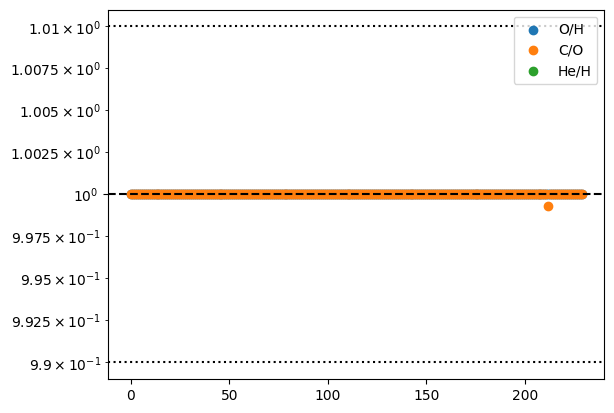

In [13]:
idx = out_targetlist["Redox [Reduced = 0, Oxidized = 1]"] == 1
print(len(out_targetlist), len(idx))
plt.scatter(np.arange(len(out_targetlist[idx])), out_targetlist["O/H_profile"][idx]/out_targetlist["OHratio"][idx], label="O/H")
plt.scatter(np.arange(len(out_targetlist[idx])), out_targetlist["C/O_profile"][idx]/out_targetlist["COratio"][idx], label="C/O")
plt.scatter(np.arange(len(out_targetlist[idx])), out_targetlist["He/H_profile"][idx]/out_targetlist["HeHratio"][idx], label="He/H")
plt.axhline(1, color='k', linestyle='--')
plt.axhline(1.01, color='k', linestyle=':')
plt.axhline(0.99, color='k', linestyle=':')
plt.yscale("log")
plt.legend()

# idx = np.where(out_targetlist["O/H_profile"]/out_targetlist["OHratio"]>2)
# print(len(idx[0]))
# print(idx)
# print(out_targetlist["Planet Name"][out_targetlist["O/H_profile"]/out_targetlist["OHratio"]>2])